# Advanced Machine Learning Lab (PDS2101)


Submitted By : Subrat Ku Nanda

## Experiment - 5
Aim of your experiment : CIFAR10 Transfer Learning based Classifier

### Theory :

**Introduction**

ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) is an annual event to showcase and challenge computer vision models. In the 2014 ImageNet challenge, Karen Simonyan & Andrew Zisserman from Visual Geometry Group, Department of Engineering Science, University of Oxford showcased their model in the paper titled “VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION,” which won the 1st and 2nd place in object detection and classification. The original paper can be downloaded from the below link:

**What is VGG16**

A convolutional neural network is also known as a ConvNet, which is a kind of artificial neural network. A convolutional neural network has an input layer, an output layer, and various hidden layers. VGG16 is a type of CNN (Convolutional Neural Network) that is considered to be one of the best computer vision models to date. The creators of this model evaluated the networks and increased the depth using an architecture with very small (3 × 3) convolution filters, which showed a significant improvement on the prior-art configurations. They pushed the depth to 16–19 weight layers making it approx — 138 trainable parameters.

**What is VGG16 used for**

VGG16 is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with transfer learning.

**VGG16 Architecture**


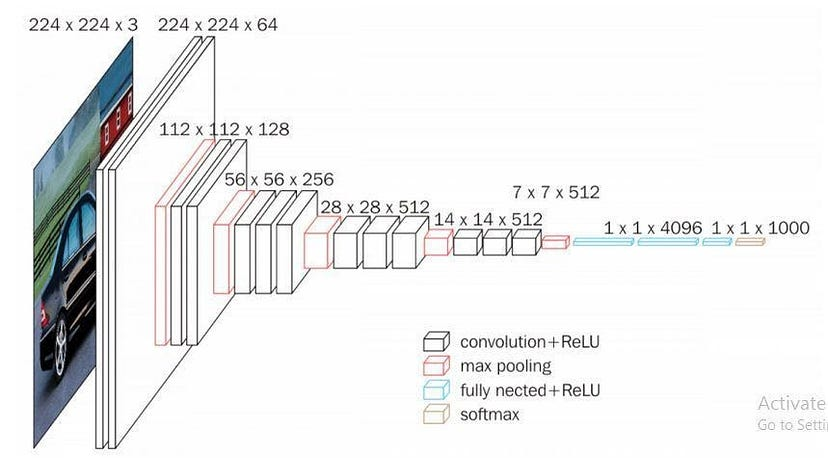

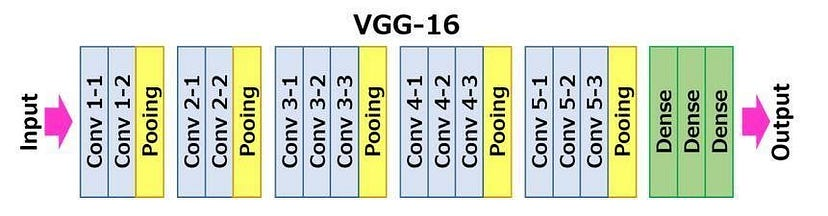

- The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.

- VGG16 takes input tensor size as 224, 244 with 3 RGB channel

- Most unique thing about VGG16 is that instead of having a large number of hyper-parameters they focused on having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 2.

- The convolution and max pool layers are consistently arranged throughout the whole architecture

- Conv-1 Layer has 64 number of filters, Conv-2 has 128 filters, Conv-3 has 256 filters, Conv 4 and Conv 5 has 512 filters.

- Three Fully-Connected (FC) layers follow a stack of convolutional layers: the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer.

### Code

#### Import Library

In [2]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
import skimage
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
%matplotlib inline

In [51]:
import tensorflow as tf
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
#from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix

#### Load and Prepare DataSet

In [4]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Cifar 10 dataset: “consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.”

CIFAR 10 Dataset: 6000 colr images of size (30X30X3)


In [6]:
# Split training dataset in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=np.array(y_train), random_state=42)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


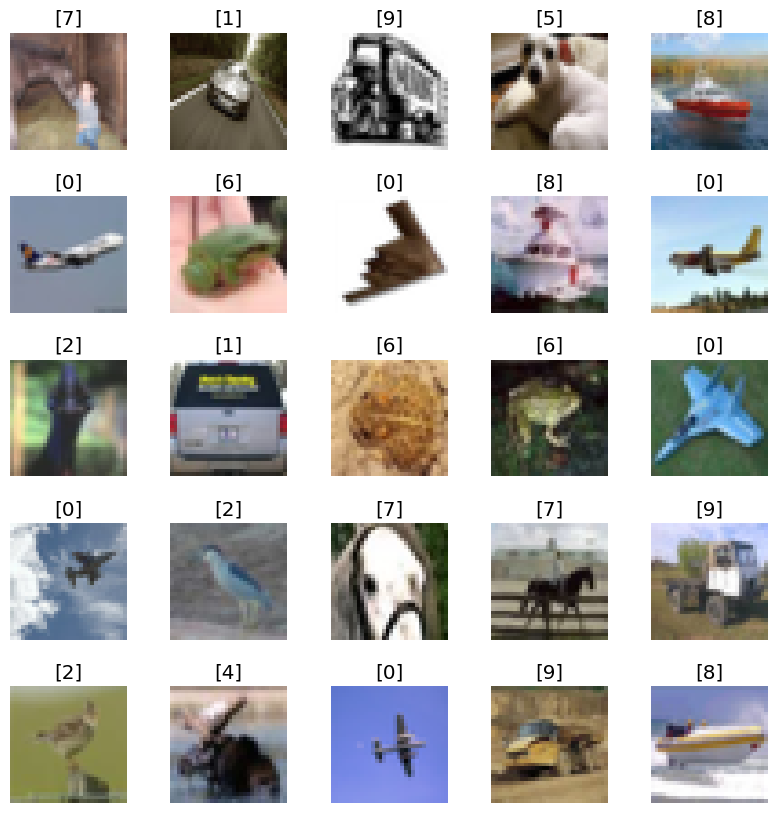

In [7]:
W_grid=5
L_grid=5
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(X_train)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) 
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index]) 
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [8]:
## Transform target variable/labels into one hot encoded form
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

#### Preprocessing

In [9]:
#Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48. 
##We utilize ```scipy`` to resize images to required dimensions

X_train = np.array([skimage.transform.resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([skimage.transform.resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([skimage.transform.resize(x, 
                                    (48, 48)) for x in X_test])

#### Prepare the Model




*   Load VGG16 without the top classification layer.
*   Prepare a custom classifier
*   Stack both models on top of each other.




In [10]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [11]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [12]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [13]:
for layer in base_model.layers:
     layer.trainable = False

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

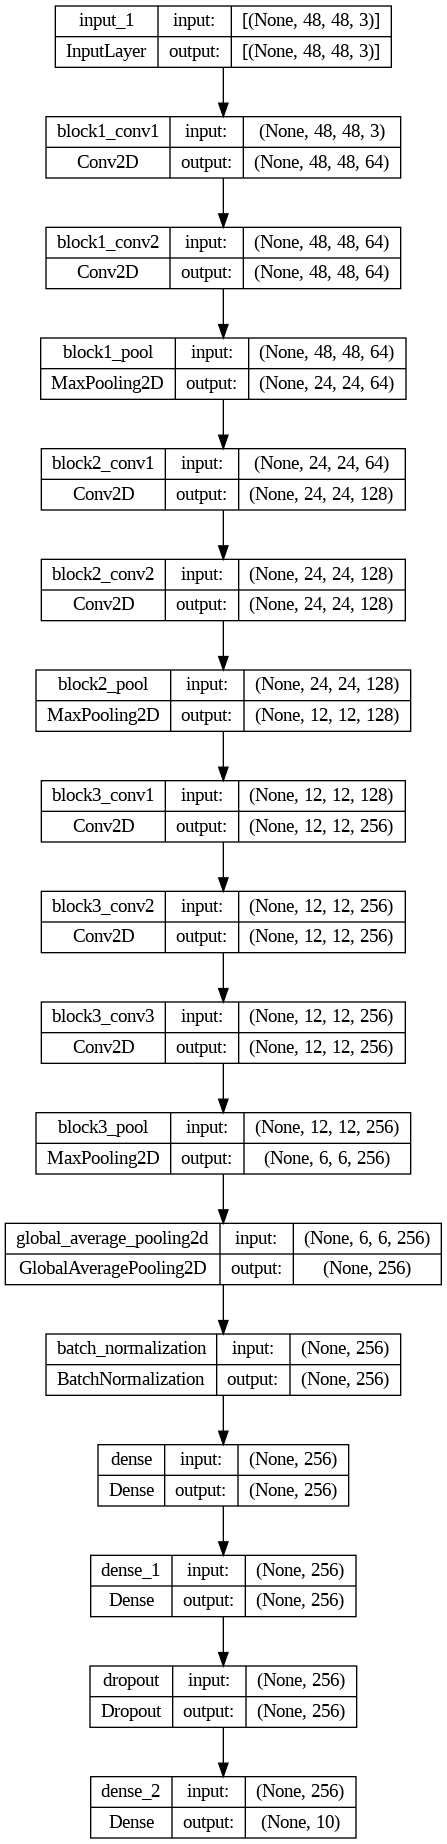

In [16]:
#tf.keras.utils.plot_model(model, to_file='cnn_fmnist.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model, to_file='cifar10-vgg16.png', show_shapes=True, show_layer_names=True)

#### Data Augmentation

In [17]:
# To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras utilities

In [18]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [19]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [20]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [23]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

In [24]:
print('train_steps_per_epoch : ',train_steps_per_epoch)
print('val_steps_per_epoch : ',val_steps_per_epoch)

train_steps_per_epoch :  1328
val_steps_per_epoch :  234


#### Train the Model

In [32]:

#train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
#val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              callbacks=[early_stopping_cb],
                              verbose=1)


Epoch 1/40
  12/1328 [..............................] - ETA: 13s - loss: 0.1868 - accuracy: 0.5911

<ipython-input-32-6095a8ee509f>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


1328/1328 [==============================] - 14s 10ms/step - loss: 0.1781 - accuracy: 0.6158 - val_loss: 0.1683 - val_accuracy: 0.6331
Epoch 2/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1766 - accuracy: 0.6192 - val_loss: 0.1664 - val_accuracy: 0.6392
Epoch 3/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1743 - accuracy: 0.6254 - val_loss: 0.1654 - val_accuracy: 0.6442
Epoch 4/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1733 - accuracy: 0.6264 - val_loss: 0.1642 - val_accuracy: 0.6440
Epoch 5/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1712 - accuracy: 0.6347 - val_loss: 0.1630 - val_accuracy: 0.6452
Epoch 6/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1696 - accuracy: 0.6357 - val_loss: 0.1624 - val_accuracy: 0.6493
Epoch 7/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1687 - accuracy: 0.6395 - val_loss: 0.1615 - val_accuracy

In [ ]:
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = model.fit_generator(steps_per_epoch=1000, #train_steps_per_epoch,
                           generator=train_generator,
                           validation_data= val_generator, 
                           validation_steps=100, #val_steps_per_epoch,
                           epochs=10,
                           callbacks=[checkpoint,early])

'''

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Analyze Model Performance

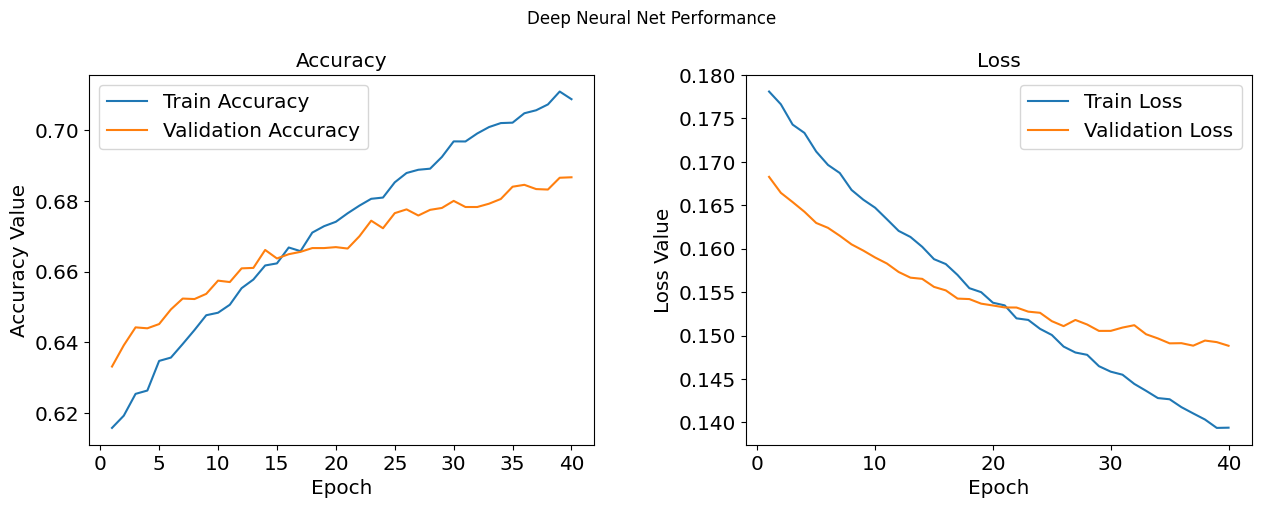

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, len(epochs)+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, len(epochs)+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#### Making predictions

In [47]:
#Making prediction
y_pred=model.predict(X_test/255.)
y_true=list(y_test.squeeze()) 
y_pred=list(y_pred.argmax(axis=1))#np.argmax(Y_test,axis=1)

313/313 [==============================] - 2s 6ms/step


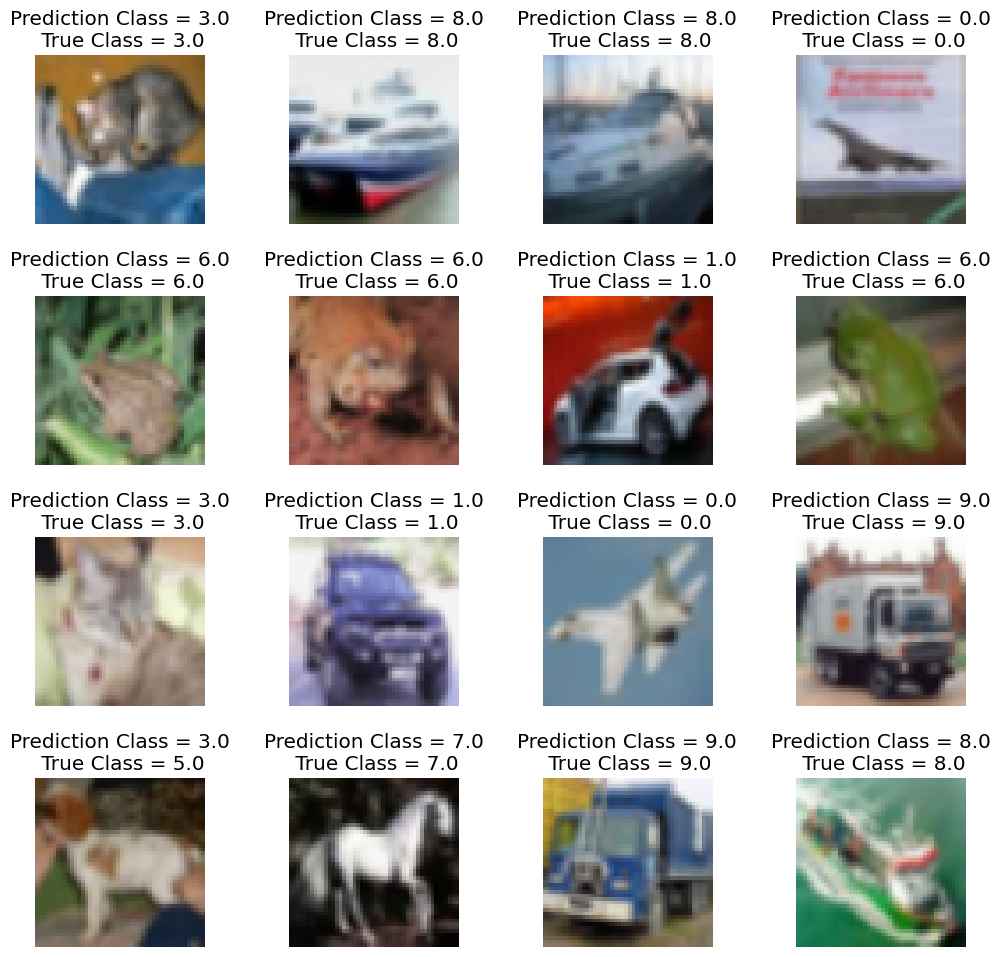

In [48]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {y_pred[i]:0.1f}\n True Class = {y_true[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [63]:
#Accuracy of VGG16
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred);
print ( "Model Accuracy :",acc*100)

Model Accuracy : 68.8


#### Evaluating the performance

Confusion matrix

In [49]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [52]:
#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [53]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

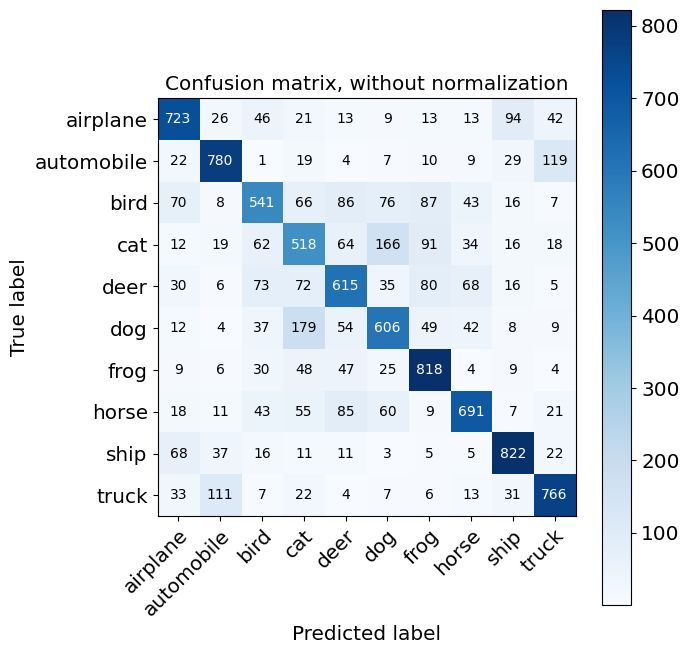

In [54]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

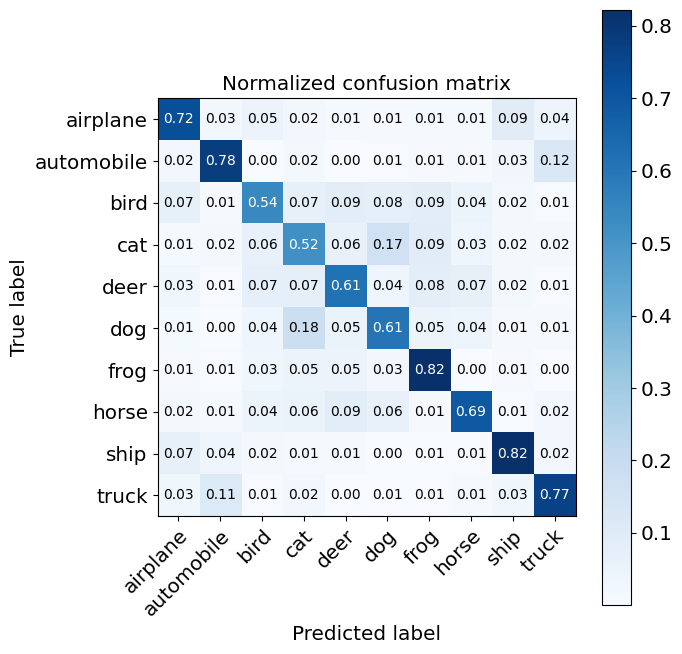

In [55]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Classification Report

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1000
           1       0.77      0.78      0.78      1000
           2       0.63      0.54      0.58      1000
           3       0.51      0.52      0.52      1000
           4       0.63      0.61      0.62      1000
           5       0.61      0.61      0.61      1000
           6       0.70      0.82      0.75      1000
           7       0.75      0.69      0.72      1000
           8       0.78      0.82      0.80      1000
           9       0.76      0.77      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



#### Reference Reading
[Practical Comparison of Transfer Learning Models in Multi-Class Image Classification](https://analyticsindiamag.com/practical-comparison-of-transfer-learning-models-in-multi-class-image-classification/)